In [1]:
# File processing
import os

# Data processing
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Machine Learning
import random
import torch
import torch.nn.functional as F
from torch import linalg as LAtorch
from numpy import linalg as LAnumpy
from scipy.spatial import distance_matrix

# Data display 
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.legend_handler import HandlerLine2D

# Set device type
device = torch.device('cpu')

# Constants

In [2]:
# Models constants
SEED = 0
EMBEDDING_SIZE = 3 # Euclidean 3D space

# Trussart test set constants
NB_BINS = 202
TRUSSART_HIC_PATH = '../../data/trussart/hic_matrices/150_TADlike_alpha_150_set0.mat'
TRUSSART_STRUCTURES_PATH = '../../data/trussart/structure_matrices/'
NB_TRUSSART_STRUCTURES = 100

# TREACH3D 
TREACH3D_LINEAR_STRUCTURE_PATH = 'experiment_results/linear/non_ae_synthetic_random_linear_trussart_test_structure_150_0.1.txt'

# REACH3D
REACH3D_STRUCTURE_PATH = 'experiment_results/reach3d/reach3d_trussart_output_structure_150.txt'

# GEM 
GEM_STRUCTURE_PATH = 'experiment_results/gem/trussart_structure_formatted_150.txt'

# miniMDS
MINIMDS_STRUCTURE_PATH = 'experiment_results/minimds/trussart_structure_formatted_150.txt'

# Seeds

In [3]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Create dataset

## Hic matrice

In [4]:
trussart_hic = np.loadtxt(TRUSSART_HIC_PATH, dtype='f', delimiter='\t')
scaler = MinMaxScaler()
trussart_hic = scaler.fit_transform(trussart_hic)

## Structure matrices

In [5]:
trussart_structures = []

file_list = os.listdir(TRUSSART_STRUCTURES_PATH)
file_list = filter(lambda f: f.endswith('.xyz'), file_list)

for file_name in file_list:
    current_trussart_structure = np.loadtxt(TRUSSART_STRUCTURES_PATH + file_name, dtype='f', delimiter='\t')
    current_trussart_structure = current_trussart_structure[:,1:]
    trussart_structures.append(current_trussart_structure)

# Structure analysis functions

### Torch

In [6]:
def centralize_torch(z):
    return z - torch.repeat_interleave(torch.reshape(torch.mean(z, axis=1), (-1,1,EMBEDDING_SIZE)), NB_BINS, dim=1)

In [7]:
def normalize_torch(z):
    
    norms = LAtorch.norm(z, 2, dim=2)
    max_norms, _ = torch.max(norms, axis=1)
    max_norms = torch.reshape(max_norms, (BATCH_SIZE,1,1))
    max_norms = torch.repeat_interleave(max_norms, NB_BINS, dim=1)
    max_norms = torch.repeat_interleave(max_norms, EMBEDDING_SIZE, dim=2)
    max_norms[max_norms == 0] = 1
    
    return z / max_norms

In [8]:
def centralize_and_normalize_torch(z):
    
    # Translate
    z = centralize_torch(z)
    
    # Scale
    z = normalize_torch(z)
    
    return z

### Numpy

In [9]:
def centralize_numpy(z):
    return z - np.mean(z, axis=0)

In [10]:
def normalize_numpy(z):
    
    norm = LAnumpy.norm(z, 2, axis=1)
    max_norm = np.max(norm, axis=0)
    if max_norm == 0:
        max_norm = 1
    
    return z / max_norm

In [11]:
def centralize_and_normalize_numpy(z):
    
    # Translate
    z = centralize_numpy(z)
    
    # Scale
    z = normalize_numpy(z)
    
    return z

In [12]:
def kabsch_superimposition_numpy(pred_structure, true_structure):
    
    # Centralize and normalize to unit ball
    pred_structure_unit_ball = centralize_and_normalize_numpy(pred_structure)
    true_structure_unit_ball = centralize_and_normalize_numpy(true_structure)
    
    # Rotation (solution for the constrained orthogonal Procrustes problem, subject to det(R) = 1)
    m = np.matmul(np.transpose(true_structure_unit_ball), pred_structure_unit_ball)
    u, s, vh = np.linalg.svd(m)
    
    d = np.sign(np.linalg.det(np.matmul(u, vh)))
    a = np.eye(EMBEDDING_SIZE)
    a[-1,-1] = d
    
    r = np.matmul(np.matmul(u, a), vh)
    
    pred_structure_unit_ball = np.transpose(np.matmul(r, np.transpose(pred_structure_unit_ball)))
    
    return pred_structure_unit_ball, true_structure_unit_ball

In [13]:
def kabsch_distance_numpy(pred_structure, true_structure):
    
    pred_structure_unit_ball, true_structure_unit_ball = kabsch_superimposition_numpy(pred_structure, true_structure)
    
    # Structure comparison
    d = np.mean(np.sum(np.square(pred_structure_unit_ball - true_structure_unit_ball), axis=1))
    
    return d

# Import previous works structures

## REACH-3D

In [14]:
reach3d_structure = np.loadtxt(REACH3D_STRUCTURE_PATH, dtype='f', delimiter='\t')

## MiniMDS

In [15]:
minimds_structure = np.loadtxt(MINIMDS_STRUCTURE_PATH, dtype='f', delimiter=' ')

## GEM

In [16]:
gem_structure = np.loadtxt(GEM_STRUCTURE_PATH, dtype='f', delimiter='\t')

# Import tREACH-3D structures

##### Non AE Synthetic random linear

In [17]:
treach3d_linear_structure = np.loadtxt(TREACH3D_LINEAR_STRUCTURE_PATH, dtype='f', delimiter=' ')

##### Non AE Synthetic random bi-lstm

In [18]:
# treach3d_bi_lstm_structure = np.loadtxt(TREACH3D_BI_LSTM_STRUCTURE_PATH, dtype='f', delimiter=' ')

# Compute the Trussart Kabsch distances

In [19]:
def compute_kabsch_distance_distribution(pred_structure):
    
    kabsch_distance_distribution = []
    for true_structure in trussart_structures:
        kabsch_distance_distribution.append(kabsch_distance_numpy(pred_structure, true_structure))
        
    return kabsch_distance_distribution

## Previous works

In [20]:
reach3d_distribution = compute_kabsch_distance_distribution(reach3d_structure)
gem_distribution = compute_kabsch_distance_distribution(gem_structure)
minimds_distribution = compute_kabsch_distance_distribution(minimds_structure)

### tReach3D

In [21]:
treach3d_linear_distribution = compute_kabsch_distance_distribution(treach3d_linear_structure)
# treach3d_bi_lstm_distribution = compute_kabsch_distance_distribution(treach3d_bi_lstm_structure)

## Random prediction threshold

In [22]:
def random_prediction(nb_bins):
    
    # Random r's
    r_s = np.random.uniform(low=0, high=1, size=nb_bins)
    
    # Random theta's
    theta_s = np.random.uniform(low=0, high=np.pi, size=nb_bins)
    
    # Random phi's
    phi_s = np.random.uniform(low=0, high=2*np.pi, size=nb_bins)
    
    final_structure = []
    for i in range(nb_bins):
        x = r_s[i] * np.cos(phi_s[i]) * np.sin(theta_s[i])
        y = r_s[i] * np.sin(phi_s[i]) * np.sin(theta_s[i])
        z = r_s[i] * np.cos(theta_s[i])
        final_structure.append([x, y, z])
        
    return np.asarray(final_structure).reshape((nb_bins, EMBEDDING_SIZE))

In [23]:
random_structure = random_prediction(NB_BINS)
random_distribution = compute_kabsch_distance_distribution(random_structure)

## Prefect prediction threshold

In [24]:
perfect_structure = np.mean(trussart_structures, axis=0)
perfect_distribution  = compute_kabsch_distance_distribution(perfect_structure)

# Test good load of structures

In [25]:
perfect_structure = centralize_and_normalize_numpy(perfect_structure)

treach3d_linear_structure, treach3d_linear_structure_perfect = \
    kabsch_superimposition_numpy(treach3d_linear_structure, perfect_structure)

reach3d_structure, reach3d_structure_perfect = \
    kabsch_superimposition_numpy(reach3d_structure, perfect_structure)

minimds_structure, minimds_structure_perfect = \
    kabsch_superimposition_numpy(minimds_structure, perfect_structure)

gem_structure, gem_structure_perfect = \
    kabsch_superimposition_numpy(gem_structure, perfect_structure)

random_structure, random_structure_perfect = \
    kabsch_superimposition_numpy(random_structure, perfect_structure)

In [26]:
d_perfect_structure = \
    np.diagonal(distance_matrix(perfect_structure, perfect_structure), offset=1)
d_treach3d_linear_structure = \
    np.diagonal(distance_matrix(treach3d_linear_structure, treach3d_linear_structure), offset=1)
d_reach3d_linear_structure = \
    np.diagonal(distance_matrix(reach3d_structure, reach3d_structure), offset=1)
d_minimds_structure = \
    np.diagonal(distance_matrix(minimds_structure, minimds_structure), offset=1)
d_gem_structure = \
    np.diagonal(distance_matrix(gem_structure, gem_structure), offset=1)
d_random_structure = \
    np.diagonal(distance_matrix(random_structure, random_structure), offset=1)

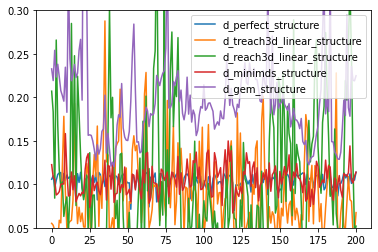

In [27]:
plt.plot(d_perfect_structure, label='d_perfect_structure')
plt.plot(d_treach3d_linear_structure, label='d_treach3d_linear_structure')
plt.plot(d_reach3d_linear_structure, label='d_reach3d_linear_structure')
plt.plot(d_minimds_structure, label='d_minimds_structure')
plt.plot(d_gem_structure, label='d_gem_structure')

plt.ylim(0.05, 0.3)

plt.legend()
plt.show()

In [28]:
print(np.var(d_perfect_structure))
print(np.var(d_minimds_structure))
print(np.var(d_treach3d_linear_structure))
print(np.var(d_gem_structure))
print(np.var(d_reach3d_linear_structure))
print(np.var(d_random_structure))

7.066907592333244e-05
0.0002767888808274529
0.002061249962511869
0.0024874195399311318
0.005934687988866753
0.11370381182665885


## Final plot

### Distribution means

In [29]:
reach3d_mean = np.mean(reach3d_distribution)
gem_mean = np.mean(gem_distribution)
minimds_mean = np.mean(minimds_distribution)

In [30]:
treach3d_linear_mean = np.mean(treach3d_linear_distribution)

In [31]:
random_mean = np.mean(random_distribution)
perfect_mean = np.mean(perfect_distribution)

### Randering

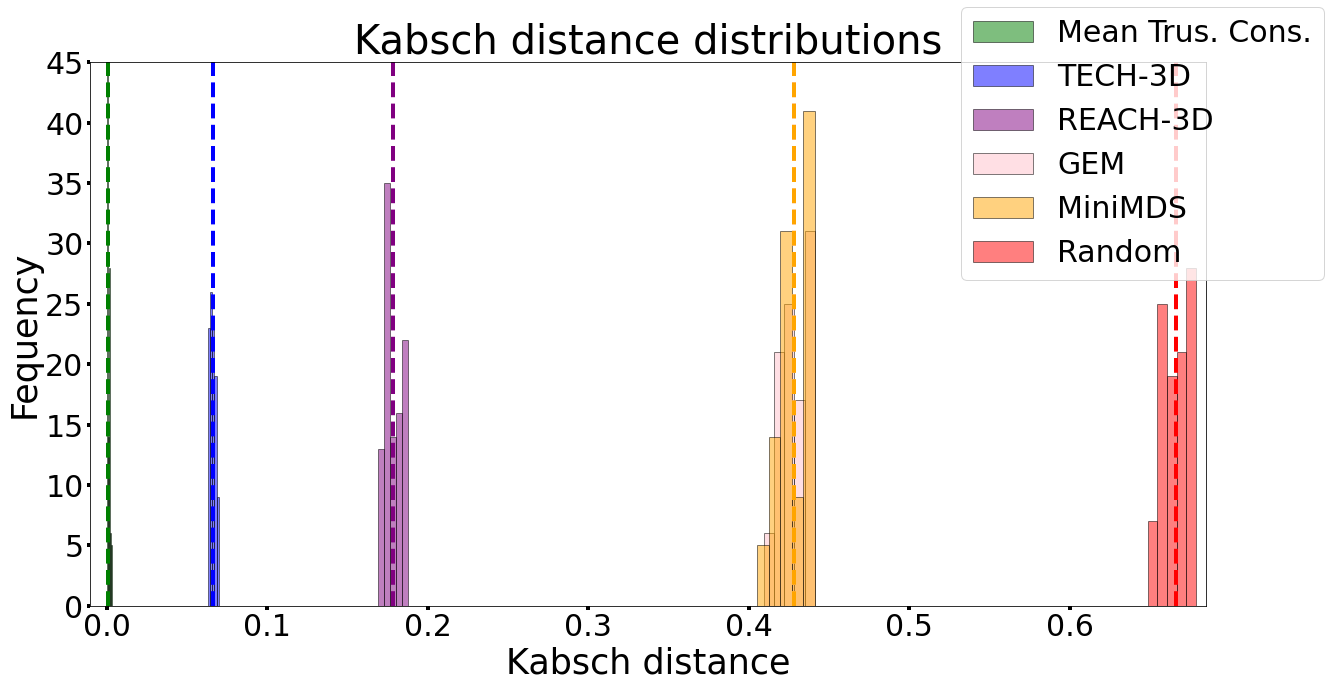

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(20,10))

## Histograms
axs.hist(perfect_distribution, facecolor='green', label='Mean Trus. Cons.', alpha=0.5, edgecolor='black', linewidth=1, bins=5)
axs.axvline(perfect_mean, color='green', linestyle='dashed', linewidth=4)

axs.hist(treach3d_linear_distribution, facecolor='blue', label='TECH-3D', alpha=0.5, edgecolor='black', linewidth=1, bins=5)
axs.axvline(treach3d_linear_mean, color='blue', linestyle='dashed', linewidth=4)

axs.hist(reach3d_distribution, facecolor='purple', label='REACH-3D', alpha=0.5, edgecolor='black', linewidth=1, bins=5)
axs.axvline(reach3d_mean, color='purple', linestyle='dashed', linewidth=4)

axs.hist(gem_distribution, facecolor='pink', label='GEM', alpha=0.5, edgecolor='black', linewidth=1, bins=5)
axs.axvline(gem_mean, color='pink', linestyle='dashed', linewidth=4)

axs.hist(minimds_distribution, facecolor='orange', label='MiniMDS', alpha=0.5, edgecolor='black', linewidth=1, bins=5)
axs.axvline(minimds_mean, color='orange', linestyle='dashed', linewidth=4)

axs.hist(random_distribution, facecolor='red', label='Random', alpha=0.5, edgecolor='black', linewidth=1, bins=5)
axs.axvline(random_mean, color='red', linestyle='dashed', linewidth=4)

## Titles
axs.set_title('Kabsch distance distributions', fontsize=40)
axs.set_xlabel('Kabsch distance', fontsize=35)
axs.set_ylabel('Fequency', fontsize=35)
axs.legend(fontsize=35)

axs.tick_params(axis='both', which='major', labelsize=30, width=4)

## Axis limits
axs.set_xlim(-0.01, 0.685)
axs.set_ylim(0, 45)
plt.legend(fontsize=30, loc=(0.78, 0.6))

plt.savefig('distribution_of_the_kabsch_distances_between_the_trussart_100_structures_and_the_predicted_structure_of_various_methods.png')


plt.show()